# Customer Segmentation


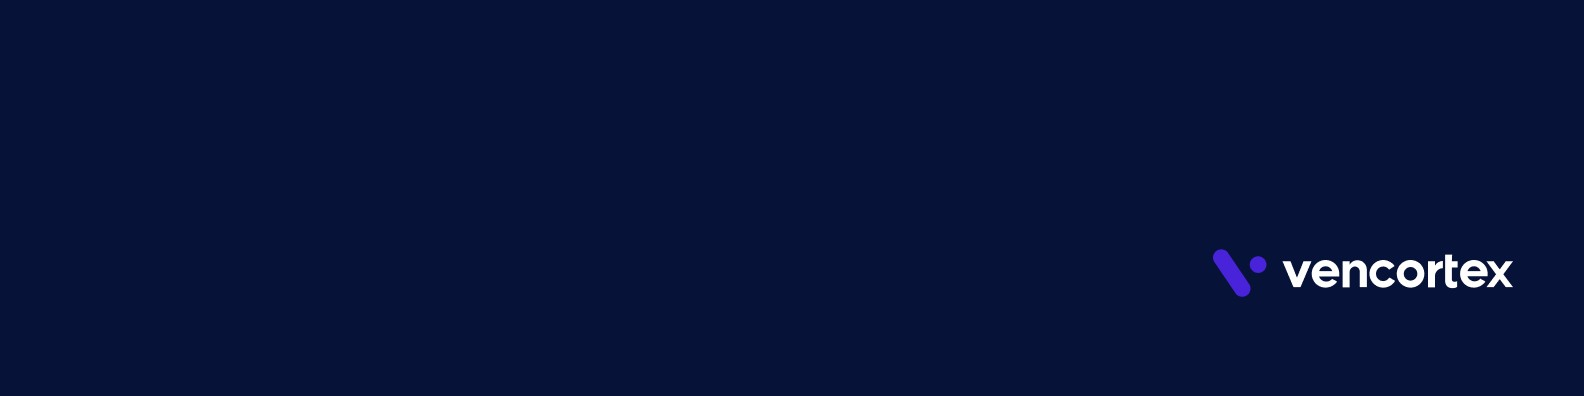

A project as a part of Vencortex hiring process to segment the customer data. The data was copied to my git repo for easy reusability across platforms. The code can be viewed by visiting this link: [Vencortex](https://colab.research.google.com/drive/1rWvN8aB05Es2vg4cbGGnF56894uAa3sy?usp=sharing) 

This notebook tries to segment the given customer data using unsupervised clustering. This allows to analyze the diffferent customer categories in the given data that can give us more insights into the dataset. This is a proof of concept and the features/parameters can be changed based on actuall task in hand.

## Task


---


The dataset contains customer features like age, gender, empolyment, amount etc. The aim is to group customer base to develop new relationships among customers. This can be approached in multiple ways with given data
- behavioural aspect (based on spending features- amount,scale, risk etc..)
- demographical aspect (based on human characteristics- age, gender etc..)

## Import libraries


---



In [105]:
# install kmodes clustering library
!pip install -q kmodes
!pip install --upgrade kmodes

Requirement already up-to-date: kmodes in /usr/local/lib/python3.7/dist-packages (0.11.0)


In [106]:
# basic libraries for vector computations and database
import numpy as np 
import pandas as pd
pd.set_option('display.max_colwidth', None)

# libraries for clustering and ranking
from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import KMeans 
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes

# libraries for visualization
from termcolor import colored
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# setting style for plots and graphs
%matplotlib inline
sns.set_context("paper")
# plt.rcParams['figure.figsize'] = (20, 10)
sns.set_style("whitegrid",{
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })

#to enable retina (high resolution) plots
%config InlineBackend.figure_format='retina'

## Load the dataset


---



In [107]:
# Download the dataset hosted in my github
!git clone https://github.com/JishnuJayaraj/datasets.git
%cd datasets/

Cloning into 'datasets'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 19 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (19/19), done.
/content/datasets/datasets/datasets


In [108]:
# Load the dataset
try:
    !unzip -qq data.zip
    data = pd.read_csv("data.csv")
    print('Customers dataset has {} samples with {} features each'.format(data.shape[0],data.shape[1]))
except:
    print ("Dataset could not be loaded! ")


Customers dataset has 1377 samples with 10 features each


## Data cleaning


---



In [109]:
# view all the available features in dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1377 entries, 0 to 1376
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             1237 non-null   float64
 1   Gender          1377 non-null   object 
 2   Employment      1377 non-null   int64  
 3   Status          1289 non-null   object 
 4   Account_type_1  1107 non-null   object 
 5   Account_type_2  834 non-null    object 
 6   Amount          1377 non-null   float64
 7   Scale           1094 non-null   float64
 8   Ziel            1377 non-null   object 
 9   Risk            265 non-null    object 
dtypes: float64(3), int64(1), object(6)
memory usage: 107.7+ KB


In [110]:
# sample data
data.sample(5)

,Age,Gender,Employment,Status,Account_type_1,Account_type_2,Amount,Scale,Ziel,Risk
222,2.157895,female,3,C,D,NaN,3305.982906,24.0,auto,NaN
75,1.421053,male,2,A,D,A,3435.897436,NaN,eqpt,NaN
310,NaN,female,1,A,D,A,535.042735,12.0,entmt,NaN
767,2.421053,male,3,A,NaN,NaN,2116.239316,21.0,auto,Pos
811,1.473684,male,2,A,D,B,912.820513,6.0,entmt,NaN


So there are approximately 1400 customer data available. But there are also duplicate items as well as data with "**NaN**" values. Hense the data has to be cleaned before any further processing.

In [111]:
print('The number of NaN entries in the dataset')
print(data.isnull().sum())

The number of NaN entries in the dataset
Age                140
Gender               0
Employment           0
Status              88
Account_type_1     270
Account_type_2     543
Amount               0
Scale              283
Ziel                 0
Risk              1112
dtype: int64


This data cleaning actually depends on the task in hand and the data we have. Since almost 50% of the data has "NaN" values we cannot simply discard these values. So depending on the column different strategies are used.

**Age and Status:**

Since the number of "NaN" values in this column is relatively low and having average age as substitute also makes no sense, we decide to discard these rows. Same with *Status* column.


**Account type:**

This values were substituted with 'No Account' phrase inplace for NaN values.


**Scale:**

Since these are continuous values, the NaN values were substituted with column average. This would make the total average the same and is expected not to interfere with our analysis.

**Risk**

Most of the values in this column are NaN and were subtituted with 'Unknown'




In [112]:
# replacing nan values to "NULL text"
data["Account_type_1"].fillna("No Account", inplace = True)
data["Account_type_2"].fillna("No Account", inplace = True)
data["Risk"].fillna("Unknown", inplace = True)

# Average value substitution for missing values
data.Scale.fillna(value=data.Scale.mean(), inplace=True)

# remove rest of rows with NaN
data.dropna(axis=0, inplace=True)

print('Length of dataset is: ', len(data))
print('Check for missing values')
data.isna().sum()

Length of dataset is:  1159
Check for missing values


Age               0
Gender            0
Employment        0
Status            0
Account_type_1    0
Account_type_2    0
Amount            0
Scale             0
Ziel              0
Risk              0
dtype: int64

**Duplicates**

There are multiple rows with duplicate values so either it can be removed or each unique value can be given a index for referencing.

In [113]:
print('Number of duplicate rows are: ',len(data)-len(data.drop_duplicates()) )

# code to remove duplicates
# copy1.drop_duplicates(keep=False, inplace=True)

Number of duplicate rows are:  322


Each of these rows having same entries for age, gender, status, employment and account details can be viewed as same customer. So it makes sence to give them a unique identification id. So rows with similar details are given a unique id.

In [114]:
def make_identifier(df):
    """
    input: dataframe
    output:  unique integer id for similar rows in dataframe
    """
    str_id = df.apply(lambda x: '_'.join(map(str, x)), axis=1)
    return pd.factorize(str_id)[0]

data['id'] = make_identifier(data[['Gender','Status', 'Age','Employment','Account_type_1', 'Account_type_2']])

print("Number of unique customers: ", data.id.nunique())

Number of unique customers:  667


## Data exploration


---



In [115]:
# descriptive statistics of the non-object columns
data.describe()

,Age,Employment,Amount,Scale,id
count,1159.000000,1159.000000,1159.000000,1159.000000,1159.000000
mean,1.873030,1.886972,2735.940208,20.353142,286.494392
std,0.601607,0.624896,2326.738887,10.211487,185.206965
min,1.000000,0.000000,213.675214,4.000000,0.000000
25%,1.421053,2.000000,1156.837607,12.000000,125.000000
50%,1.736842,2.000000,1978.632479,20.538391,268.000000
75%,2.210526,2.000000,3352.564103,24.000000,432.500000
max,3.947368,3.000000,15747.008547,72.000000,666.000000


In [116]:
# statistics of the categorical variables
data.select_dtypes('object').nunique()

Gender            2
Status            3
Account_type_1    5
Account_type_2    4
Ziel              8
Risk              3
dtype: int64

In [117]:
# Summary of categorical values

for i in data.select_dtypes('object').columns:
    print(colored(i,'blue', attrs=['bold']))
    print(data[i].value_counts(),'\n')

Gender
male      814
female    345
Name: Gender, dtype: int64 

Status
A    841
C    199
B    119
Name: Status, dtype: int64 

Account_type_1
D             690
No Account    216
B             132
A              63
C              58
Name: Account_type_1, dtype: int64 

Account_type_2
No Account    456
A             327
B             300
C              76
Name: Account_type_2, dtype: int64 

Ziel
auto     396
entmt    322
eqpt     204
prof     122
edu       60
rep       31
other     14
apls      10
Name: Ziel, dtype: int64 

Risk
Unknown    950
Pos        141
Neg         68
Name: Risk, dtype: int64 



In [118]:
data.sample(10)

,Age,Gender,Employment,Status,Account_type_1,Account_type_2,Amount,Scale,Ziel,Risk,id
999,2.210526,male,2,A,D,A,2202.564103,12.000000,eqpt,Unknown,218
1272,2.000000,male,2,A,No Account,B,314.529915,6.000000,entmt,Unknown,66
1186,1.315789,female,2,C,D,No Account,3394.871795,24.000000,eqpt,Unknown,319
9,2.473684,male,1,A,D,No Account,2169.230769,24.000000,auto,Neg,6
1184,2.052632,female,1,A,C,A,569.230769,6.000000,auto,Unknown,123
16,1.631579,male,1,A,D,B,1647.863248,18.000000,eqpt,Unknown,13
12,1.684211,female,2,C,No Account,A,1098.290598,24.000000,auto,Unknown,9
26,1.842105,female,2,A,D,A,2084.615385,20.538391,entmt,Unknown,22
835,1.473684,male,2,A,D,A,4590.598291,36.000000,eqpt,Unknown,301
829,1.368421,male,2,A,D,B,1026.495726,24.000000,auto,Unknown,342


In [119]:
# check for missing values in any column, 
# data.isnull().sum()
data.isna().any()

Age               False
Gender            False
Employment        False
Status            False
Account_type_1    False
Account_type_2    False
Amount            False
Scale             False
Ziel              False
Risk              False
id                False
dtype: bool

## Data visualizations

Now since the data has no empty values let’s explore the data through visualizations and code to understand how different feature are related to eachothers. 


### Numerical values

Observe the statistical properties of the dataset. *corr()* function finds the pairwise correlation of all columns with numerical data

In [120]:
# pearson corellation of values
# select numerical columns

df = data[['Age','Amount','Scale']]
df.corr()

,Age,Amount,Scale
Age,1.000000,0.051595,-0.025781
Amount,0.051595,1.000000,0.564259
Scale,-0.025781,0.564259,1.000000


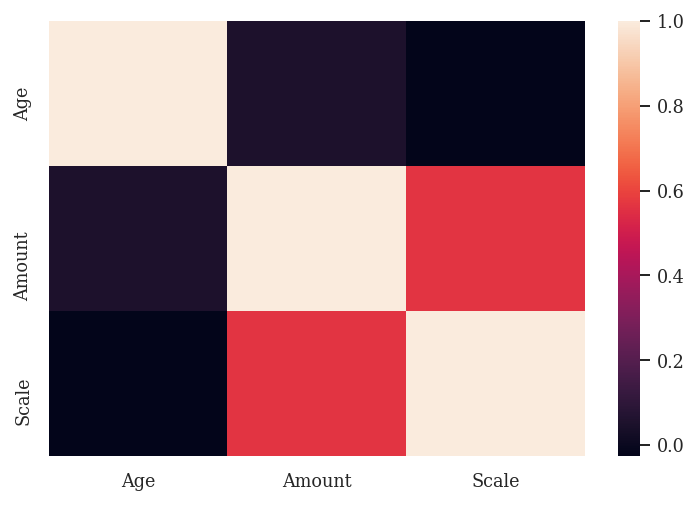

In [121]:
# Correleation heat map
corr = df.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

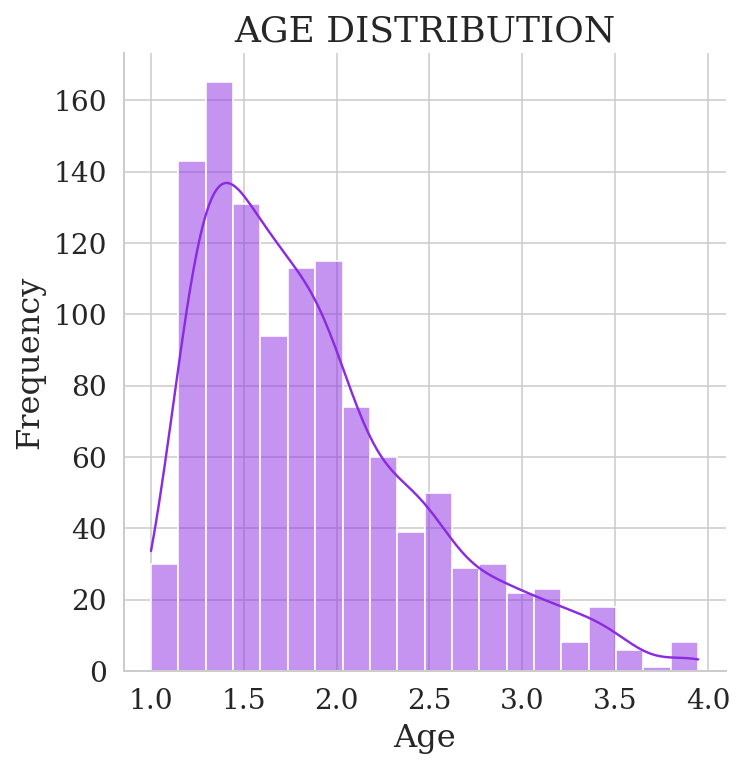

In [122]:
# Age distribution

sns.displot(data['Age'], color = 'blueviolet', kde=True)
plt.title('AGE DISTRIBUTION', fontsize = 18)
plt.xlabel('Age', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.show()

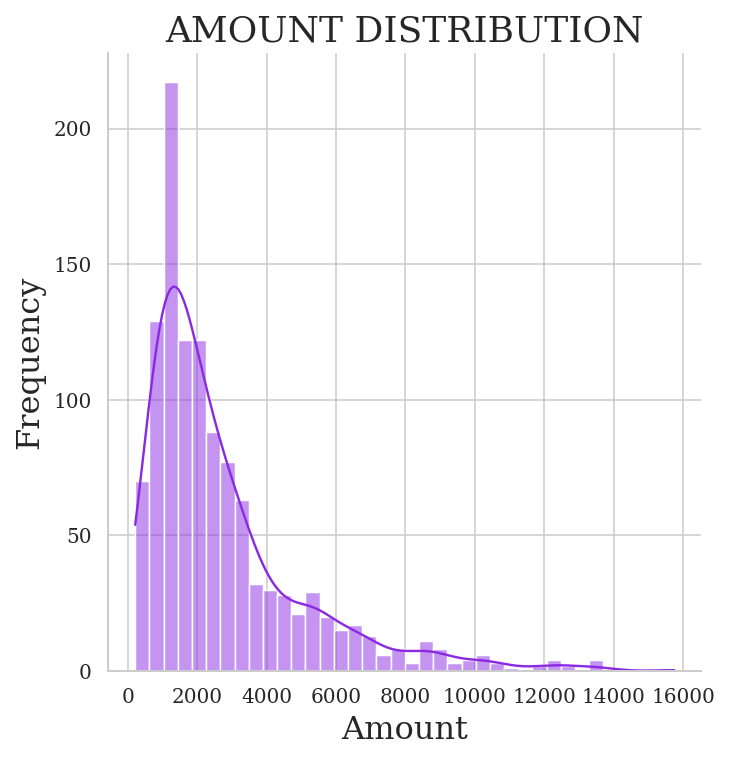

In [123]:
# Amount distribution

sns.displot(data['Amount'], color = 'blueviolet', kde=True)
plt.title('AMOUNT DISTRIBUTION', fontsize = 18)
plt.xlabel('Amount', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.show()

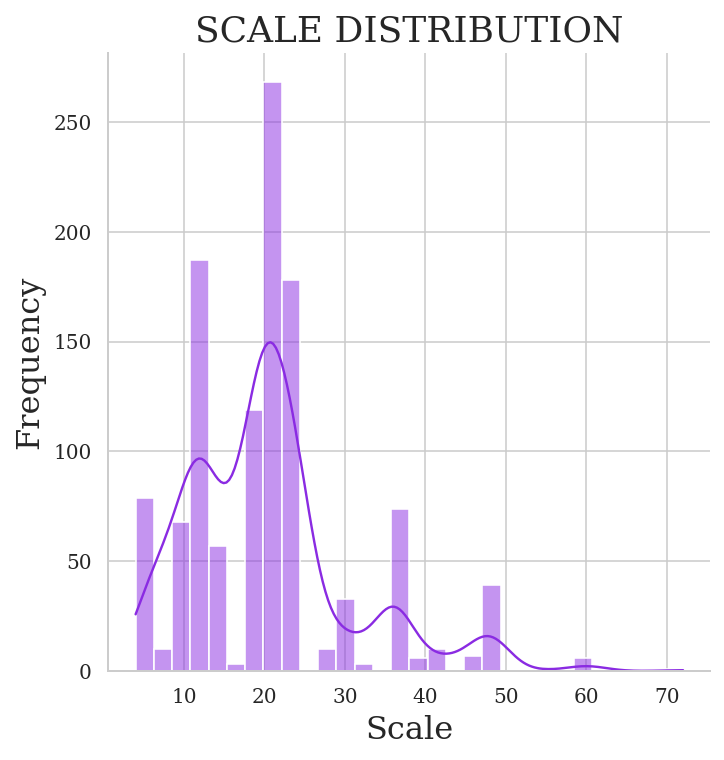

In [124]:
# Scale distribution

sns.displot(data['Scale'], color = 'blueviolet', kde=True)
plt.title('SCALE DISTRIBUTION', fontsize = 18)
plt.xlabel('Scale', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.show()

Looking at the distribution of numerical values all the plots are **positievly skewed**. 

### Categorical values

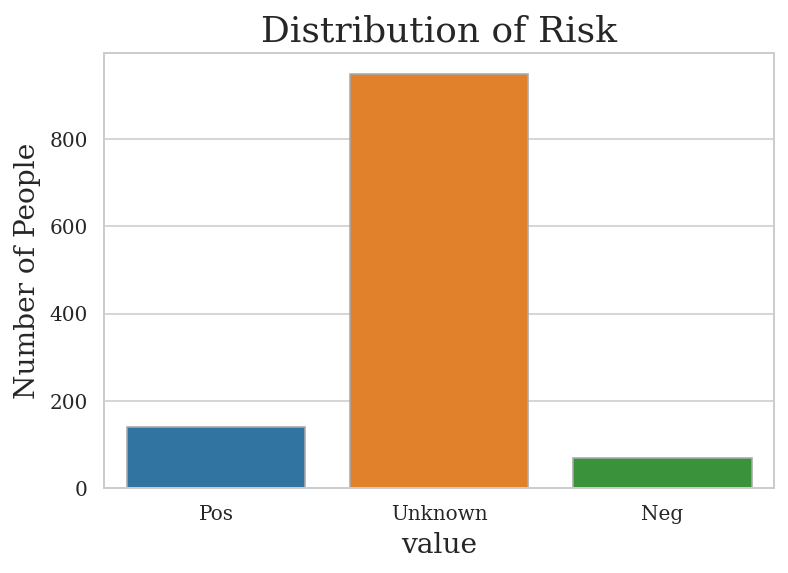

In [125]:
# Visualizing Risk statistics

sns.countplot(x=data['Risk'], edgecolor = 'darkgrey')
plt.title('Distribution of Risk', fontsize = 18)
plt.xlabel('value', fontsize = 14)
plt.ylabel('Number of People', fontsize = 14)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.show()

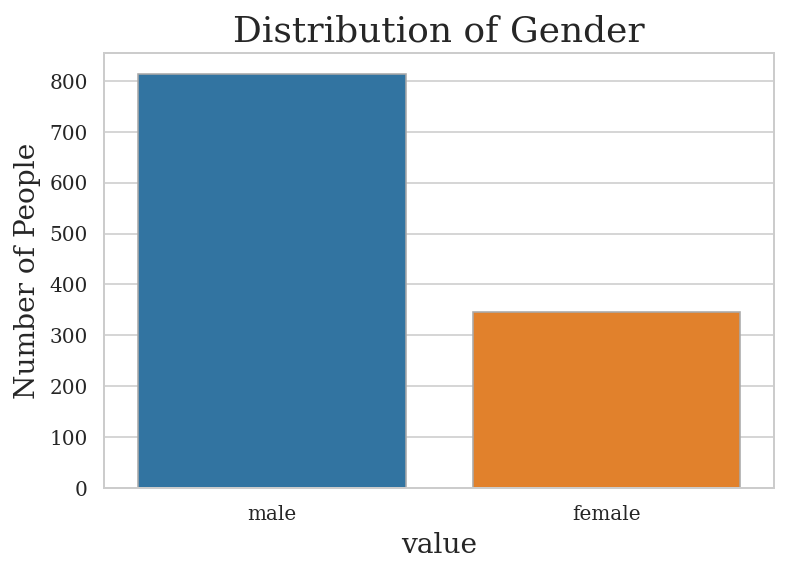

In [126]:
# Visualizing Gender statistics

sns.countplot(x=data['Gender'], edgecolor = 'darkgrey')
plt.title('Distribution of Gender', fontsize = 18)
plt.xlabel('value', fontsize = 14)
plt.ylabel('Number of People', fontsize = 14)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.show()

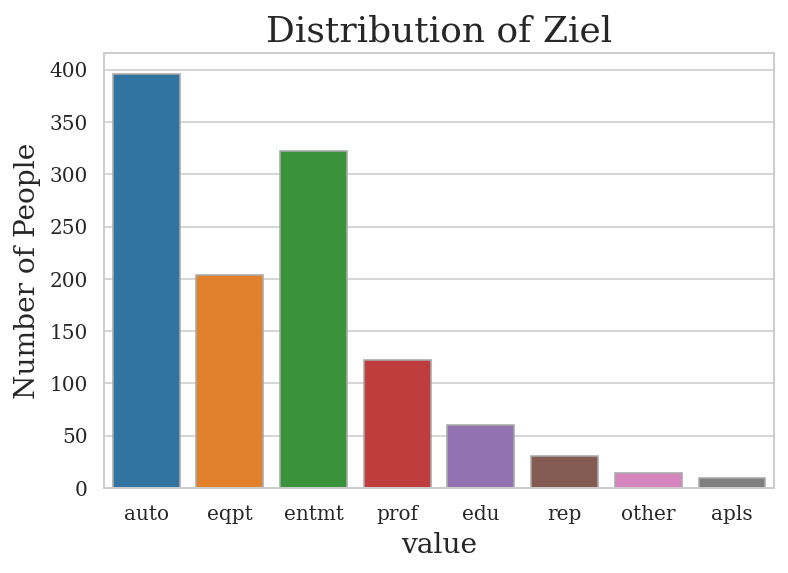

In [127]:
# Visualizing Ziel statistics

sns.countplot(x=data['Ziel'], edgecolor = 'darkgrey')
plt.title('Distribution of Ziel', fontsize = 18)
plt.xlabel('value', fontsize = 14)
plt.ylabel('Number of People', fontsize = 14)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.show()

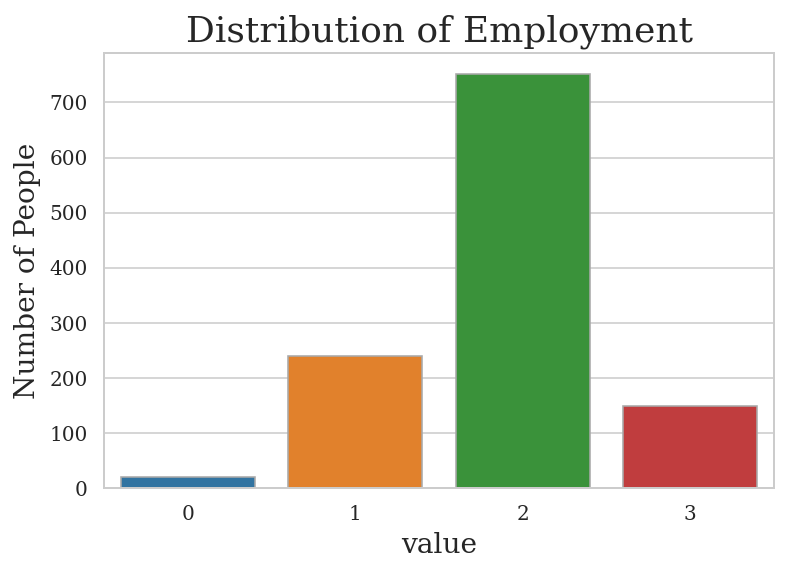

In [128]:
# Visualizing Ziel statistics

sns.countplot(x=data['Employment'], edgecolor = 'darkgrey')
plt.title('Distribution of Employment', fontsize = 18)
plt.xlabel('value', fontsize = 14)
plt.ylabel('Number of People', fontsize = 14)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.show()

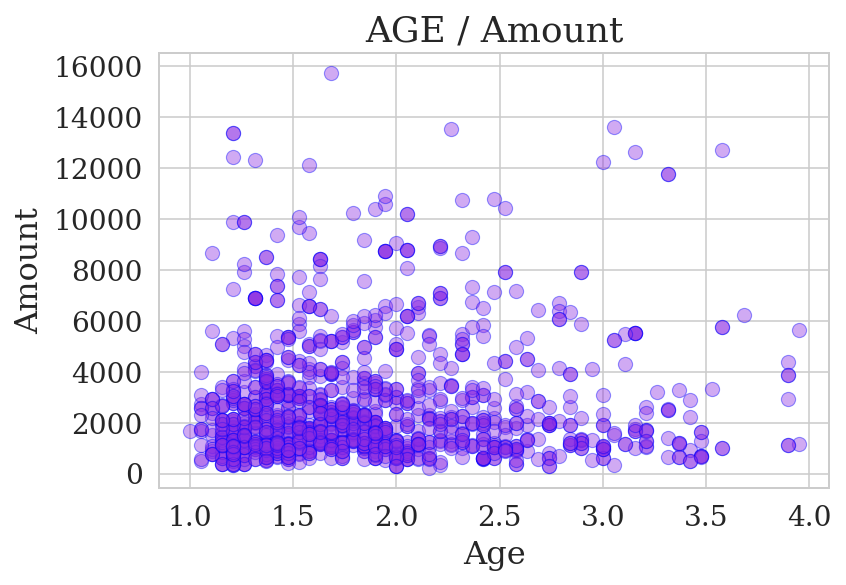

In [129]:
# Age vs Income
# plt.figure(figsize=(20, 4))
sns.scatterplot(x='Age', y='Amount', 
               data = data, 
               color = 'blueviolet', 
               s = 50, 
               alpha = 0.4, 
               edgecolor = 'b')
plt.title('AGE / Amount', 
          fontsize = 18)
plt.xlabel('Age', 
           fontsize = 16)
plt.ylabel('Amount', 
           fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)


plt.show()

From figure we can see at lower age we have more data points but lower spending. As age incrases the amount also increses in the Age of 0-1.5.

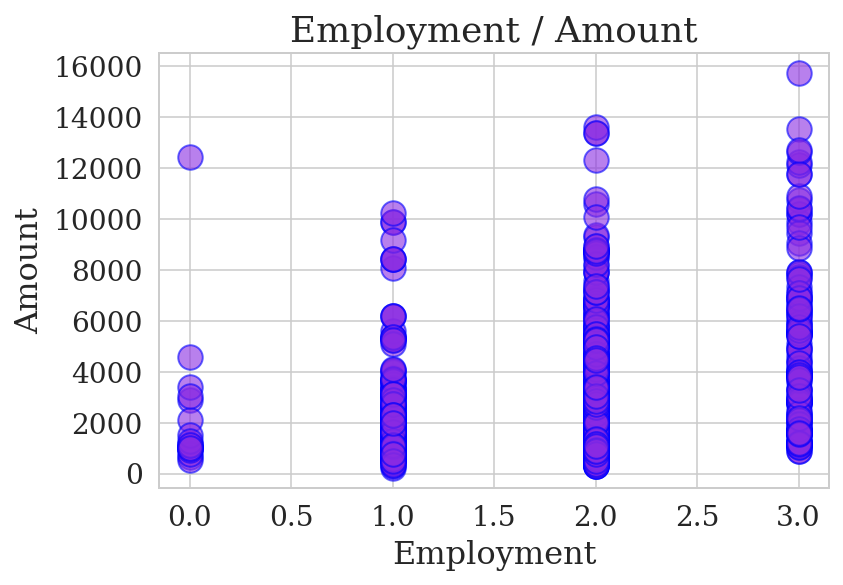

In [130]:
# Employment and amount

sns.scatterplot(x='Employment', y='Amount', data = data, 
               color = 'blueviolet', 
               s = 150, 
               alpha = 0.6, 
               edgecolor = 'b')
plt.title('Employment / Amount', 
          fontsize = 18)
plt.xlabel('Employment', 
           fontsize = 16)
plt.ylabel('Amount', 
           fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.show()

# it has a linear relationship, both increases simutaneously

Employment and amount has a linear relationship. As the employment value increases so does the amount

## Clustering

To solve this unsupervised task k-means algorithm can be used. But k-means workd efficiently only for continious numerical dataset. Encoding to categorical values to one-hot encoding works but calculating distance on one-hot encoded categorical values does not make sense according to this [article](https://www.ibm.com/support/pages/clustering-binary-data-k-means-should-be-avoided). The idea is that, it does not make sense to calculate distance between binary variables.  

**[K-Modes](https://github.com/nicodv/kmodes)** algorithm is able to find patterns in the categorical dataset. It defines clusters based on the number of [matching categories](https://ai.plainenglish.io/k-means-and-k-modes-clustering-algorithm-4ff51395fa8d) between data points comapred to eucledian distance in k-means. **The k-prototype** algorithm combines k-modes and k-means and is able to cluster mixed numerical - categorical data. 

While selecting features Gender was not selected, since it is assumed that it does not have imapct on the segmentation. Risk was also not selected because lack of useful information (60% of value is unknown!)

In [131]:
# Remove unsued columns
features = data[['Age','Amount','Scale','Status','Employment','Ziel']].copy()
print('Dimension data: {} rows and {} columns'.format(len(features), len(features.columns)))
features

Dimension data: 1159 rows and 6 columns


,Age,Amount,Scale,Status,Employment,Ziel
0,1.263158,3216.239316,21.000000,A,1,auto
2,1.368421,1645.299145,24.000000,A,2,eqpt
4,1.052632,1742.735043,18.000000,C,2,eqpt
6,2.421053,595.726496,12.000000,A,2,auto
7,3.368421,643.589744,6.000000,A,2,entmt
...,...,...,...,...,...,...
1372,1.842105,4550.427350,20.538391,B,2,auto
1373,1.421053,3035.897436,24.000000,A,2,eqpt
1374,1.368421,4485.470085,21.000000,A,2,auto
1375,1.894737,1600.000000,6.000000,B,3,eqpt


In our feature dataframe the first 3 columns are numerical and the last 3 are categorical. But the Employment column is of datatype int, hense has to be converted into object type. 

In [132]:
# use category to save memory
features['Employment'] = features.Employment.astype('object')

In [133]:
# Get the position of categorical columns
catColumnsPos = [features.columns.get_loc(col) for col in list(features.select_dtypes('object').columns)]
print('Categorical columns           : {}'.format(list(features.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

Categorical columns           : ['Status', 'Employment', 'Ziel']
Categorical columns position  : [3, 4, 5]


In [134]:
features.head()

,Age,Amount,Scale,Status,Employment,Ziel
0,1.263158,3216.239316,21.0,A,1,auto
2,1.368421,1645.299145,24.0,A,2,eqpt
4,1.052632,1742.735043,18.0,C,2,eqpt
6,2.421053,595.726496,12.0,A,2,auto
7,3.368421,643.589744,6.0,A,2,entmt


In [135]:
features
# scale amount, scale -------------------------------------------------------
scaled_features = features.copy()
scaled_features['Amount'] = np.log1p(scaled_features['Amount'])
scaled_features['Scale'] = np.log1p(scaled_features['Scale'])
scaled_features['Age'] = np.log1p(scaled_features['Age'])

# scaled_features['Amount'] = scaled_features['Amount'].apply(np.log1p())
scaled_features

,Age,Amount,Scale,Status,Employment,Ziel
0,0.816761,8.076279,3.091042,A,1,auto
2,0.862224,7.406285,3.218876,A,2,eqpt
4,0.719123,7.463785,2.944439,C,2,eqpt
6,1.229948,6.391459,2.564949,A,2,auto
7,1.474402,6.468614,1.945910,A,2,entmt
...,...,...,...,...,...,...
1372,1.044545,8.423196,3.069837,B,2,auto
1373,0.884202,8.018592,3.218876,A,2,eqpt
1374,0.862224,8.408821,3.091042,A,2,auto
1375,1.062894,7.378384,1.945910,B,3,eqpt


**Skewness in distribution**

Taking logarithm will reduce the skewness of the distribution as shown in figure below. 

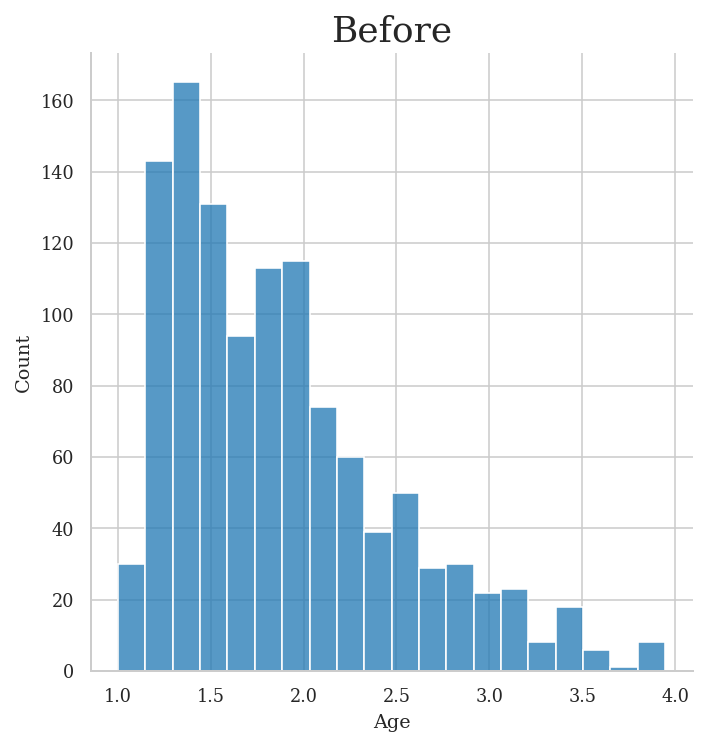

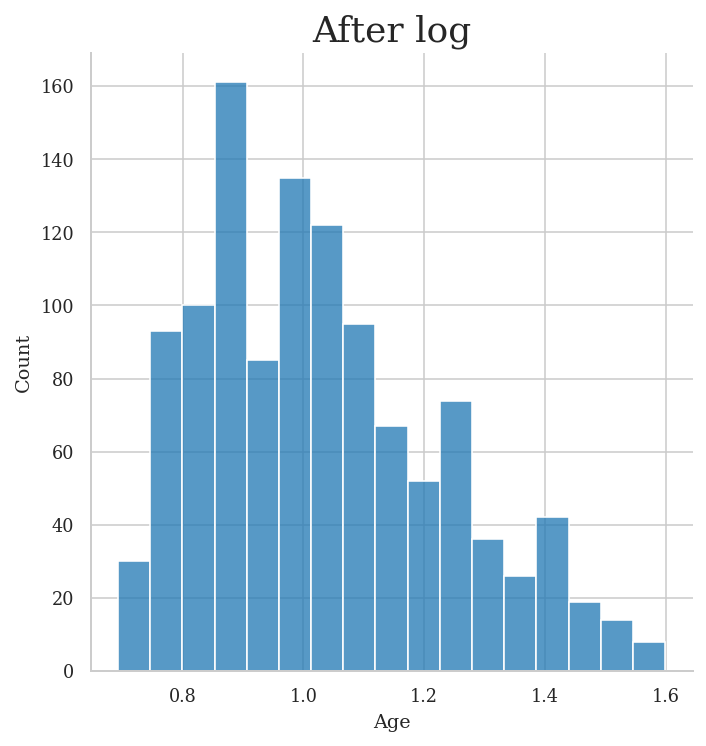

In [136]:
# Age distribution skewness

sns.displot(features['Age'])
plt.title('Before', fontsize = 18)
sns.displot(scaled_features['Age'])
plt.title('After log', fontsize = 18)

plt.show()


**Scaling**

Features like age, amount and Scale varies in different range, hense its important to scale them to equal interval. Also the distribution of features are also skewed, taking logarithm transforms a right skewed distribution can give us a symmetric distribution also while scaling down the features propotionally. Which are prerequisite in k-means algorithm.

In [137]:
from sklearn.preprocessing import StandardScaler
cols = ["Age", "Amount", "Scale"]
autoscaler = StandardScaler()
scaled_features[cols] = autoscaler.fit_transform(scaled_features[cols])
scaled_features

,Age,Amount,Scale,Status,Employment,Ziel
0,-1.112960,0.597396,0.292711,A,1,auto
2,-0.881451,-0.277630,0.558914,A,2,eqpt
4,-1.610166,-0.202534,-0.012579,C,2,eqpt
6,0.991119,-1.603014,-0.802835,A,2,auto
7,2.235952,-1.502248,-2.091933,A,2,entmt
...,...,...,...,...,...,...
1372,0.046987,1.050477,0.248552,B,2,auto
1373,-0.769528,0.522055,0.558914,A,2,eqpt
1374,-0.881451,1.031703,0.292711,A,2,auto
1375,0.140427,-0.314070,-2.091933,B,3,eqpt


In [138]:
# Convert dataframe to matrix
dfMatrix = scaled_features.to_numpy()

In [139]:
# Choosing optimal K
from kmodes.kprototypes import KPrototypes

cost = []
for cluster in range(1, 8):
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))


Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7


In [140]:
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster':range(1,len(cost)+1), 'Cost':cost})
# Show the first 5 rows
df_cost.head()

,Cluster,Cost
0,1,4221.000000
1,2,3056.070855
2,3,2491.109380
3,4,2167.167347
4,5,1986.760813


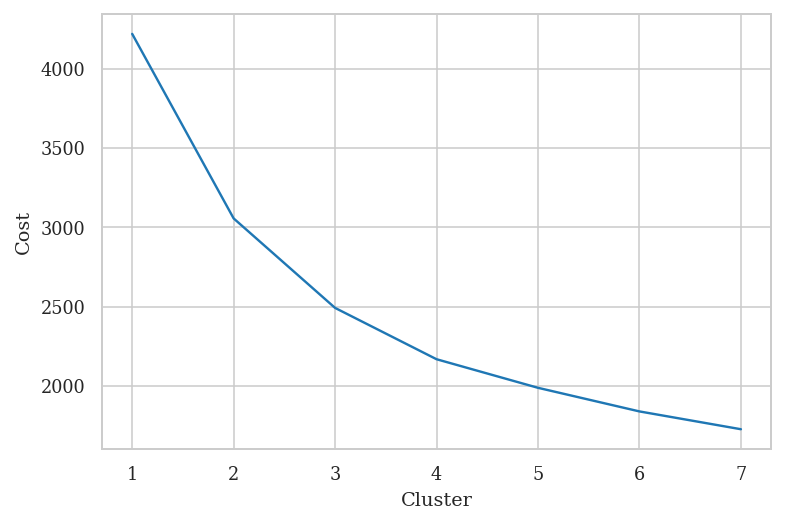

In [141]:
sns.lineplot(x='Cluster', y='Cost', data=df_cost)

The maximum slope is achieved at 3, hense hte optimum cluster number is selected to be 3. 

In [142]:
# Fit the cluster
kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 0)
kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)
# Cluster centorid
kprototype.cluster_centroids_
# Check the cost of the clusters created
kprototype.cost_
# Check the iteration of the clusters created
kprototype.n_iter_


7

In [143]:
# Add the cluster value to the dataframe
features['labels'] = kprototype.labels_
data['labels'] = kprototype.labels_
scaled_features['labels']= kprototype.labels_
_identical_cluster_labels = list(dict.fromkeys(kprototype.labels_))


In [144]:
# Cluster validation score

# features
def calc_euclian_dis(_s1, _s2):
    _eucl_dist = np.linalg.norm(_s2 - _s1)  # calculate Euclidean distance, accept input an array [2 6]
    return _eucl_dist
def calc_simpleMatching_dis(_s1, _s2):
    _cat_dist = 0
    if (_s1 != _s2):
        _cat_dist = 1
    return _cat_dist

# implimenting sillhoete index

# 1. Calculate ai
_silhouette_Index_arr = []
for i in scaled_features.itertuples():
    _ai_cluster_label = i[-1]
    # return samples of the same cluster
    _samples_cluster = scaled_features[scaled_features['labels'] == _ai_cluster_label]
    _dist_array_ai = []
    _s1_nume_att = np.array((i[1], i[2]))
    _s1_cat_att = i[3]
    for j in _samples_cluster.itertuples():
        _s2_nume_att = np.array((j[1], j[2]))
        _s2_cat_att = j[3]
        _euclian_dis = calc_euclian_dis(_s1_nume_att, _s2_nume_att)
        _cat_dis = calc_simpleMatching_dis(_s1_cat_att, _s2_cat_att)
        _dist_array_ai.append(_euclian_dis + (kprototype.gamma * _cat_dis))
    ai = np.average(_dist_array_ai)
    # 2. Calculate bi
    # 2.1. determine the samples of other clusters
    _identical_cluster_labels.remove(_ai_cluster_label)
    _dic_cluseter = {}
    _bi_arr = []
    for ii in _identical_cluster_labels:
        _samples = scaled_features[scaled_features['labels'] == ii]
        # 2.2. calculate bi
        _dist_array_bi = []
        for j in _samples.itertuples():
            _s2_nume_att = np.array((j[1], j[2]))
            _s2_cat_att = j[3]
            _euclian_dis = calc_euclian_dis(_s1_nume_att, _s2_nume_att)
            _cat_dis = calc_simpleMatching_dis(_s1_cat_att, _s2_cat_att)
            _dist_array_bi.append(_euclian_dis + (kprototype.gamma * _cat_dis))
        _bi_arr.append(np.average(_dist_array_bi))
    _identical_cluster_labels.append(_ai_cluster_label)
    # min bi is determined as final bi variable
    bi = min(_bi_arr)
    # 3. calculate silhouette Index
    if ai == bi:
        _silhouette_i = 0
    elif ai < bi:
        _silhouette_i = 1 - (ai / bi)
    elif ai > bi:
        _silhouette_i = 1 - (bi / ai)
    _silhouette_Index_arr.append(_silhouette_i)
silhouette_score = np.average(_silhouette_Index_arr)
print('_silhouette_Index = ' + str(silhouette_score))

_silhouette_Index = 0.2838553118677684


In [145]:
# get average value of each column for each clusters
features.groupby('labels').mean()

,Age,Amount,Scale
labels,,,
0,1.462039,1563.685411,16.499401
1,2.559048,1495.068104,13.745573
2,1.861763,4884.316754,29.139929


So looking at this table it can be seen that label-2 has the average age in middle age category with maximum value for Amount and Scale. Which can be seen as the middle aged people spend more?

label-1 contains the average age highest at 2.5 and has the lowest value for Amount and scale among all clusters. 



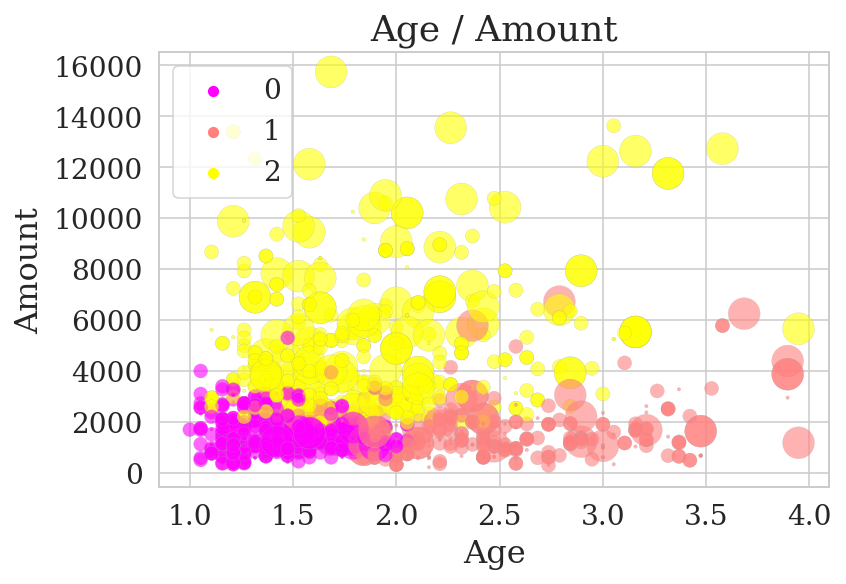

In [146]:
# education and income, color cluster bubble
area = np.pi * (features.Employment.astype(int)) ** 4

sns.scatterplot(x='Age', y='Amount', 
               data = features, 
                
               s = area,
               hue = 'labels', 
               palette = 'spring', 
               alpha = 0.6, 
               edgecolor = 'darkgrey')

plt.title('Age / Amount', 
          fontsize = 18)
plt.xlabel('Age', 
           fontsize = 16)
plt.ylabel('Amount', 
           fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(loc = 'upper left', fontsize = 14)

plt.show()

A scatter plot with Age and Amount on axis with colors indicating the cluster label. The size of the circle is determined by employment column.

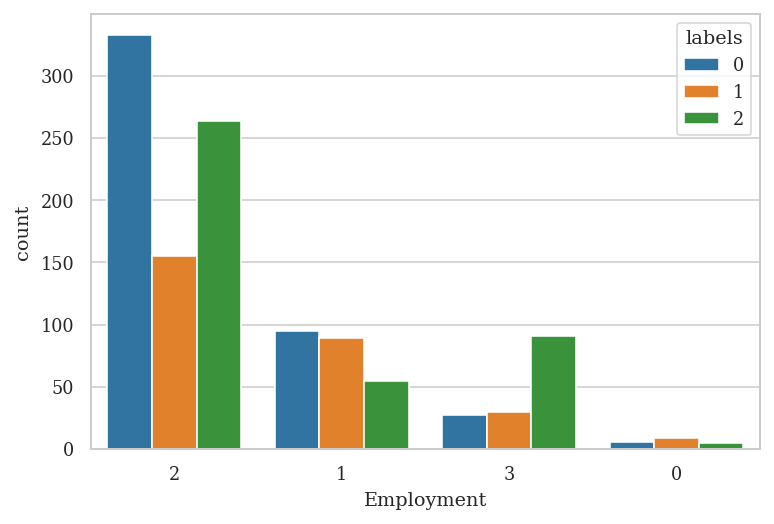

In [147]:
# Emploment comparison for different clusters
sns.countplot(x=features['Employment'],order=features['Employment'].value_counts().index,hue=features['labels'])
plt.show()

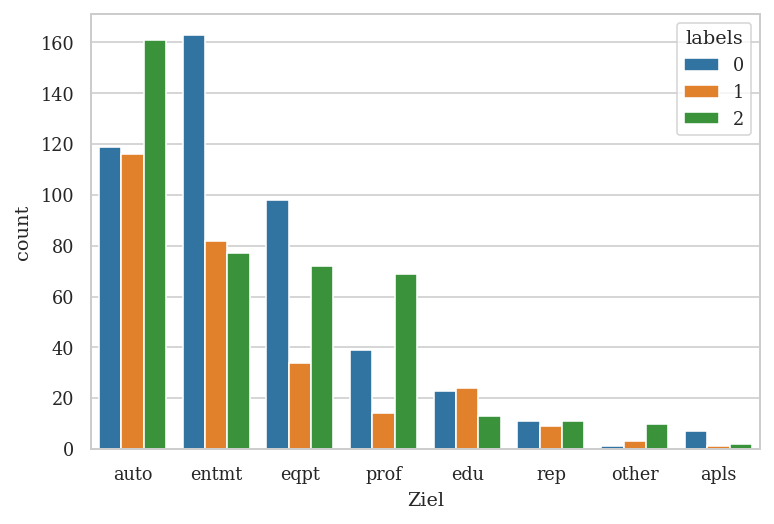

In [148]:
# Ziel
sns.countplot(x=features['Ziel'],order=features['Ziel'].value_counts().index,hue=features['labels'])
plt.show()

In [149]:
# visualize customer segmentation with a 3D plot and hover data
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = px.scatter_3d(features,
                    x="Age",
                    y="Amount",
                    z="Scale",
                    color='labels',
                    hover_data=["Ziel","Status"],
                    category_orders = {"Employment": 
                                       ["0", "1", "2", "3"]},opacity=0.6

                    )

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()